## Introduction
In this notebook, we explore fundamental theoretical aspects and limitations of function approximation using neural networks, particularly focusing on ReLU-based architectures. The story unfolds gradually, starting from necessary conditions, moving to theoretical approximation bounds, algorithms involved, and concludes with a real implementation of a ReLU-based regression network.

Each chapter includes both theoretical discussions and practical implementations when necessary, along with remarks and comparisons to reflect on how well each method performs. The motivation arises from identifying the inherent limitations of current architectures, which leads to proposing improvements or alternative methods in ongoing scientific research.

This study is largely inspired by the work of Bo Liu and Yi Liang **[1]**, which offers rigorous insights into optimal function approximation with ReLU neural networks from both theoretical and constructive perspectives.

### References

[1] Bo Liu, Yi Liang (2021). *Optimal function approximation with ReLU neural networks*, Neurocomputing, Volume 435.

## Chapter 1: Necessary and Sufficient Conditions for Optimal Approximation
In this section, we lay out the fundamental assumptions and conditions required for function approximation using neural networks. These include conditions on continuity, differentiability, and other topological properties of the function space. Rather than introducing all computational functions upfront, we explain each function when it is required for a specific result or proof.

In [1]:
cd ../..

d:\PyCharmProject\nna_24-25_pham


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from data.generators import *
from utils.trainer import train_model
from utils.evaluator import evaluate_model
from utils.visualizer import *
from utils.maths import *
from model.simple_model import FFN_Network
from typing import Callable

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 🚀 Motivation and Preliminary Experiments

When I first came across the paper  **[1]**, I noticed that the core idea of the problem closely resembles a standard regression task. This led me to wonder: Could a simple Feedforward Neural Network (FFN), typically used in regression, be applied to approximate a general function? To explore this hypothesis, I built a basic deep network to test its approximation capability — serving both as a preliminary experiment and as a motivation to later explore more theoretically grounded, optimal methods.

In [4]:
FUNCTION = lambda x: x**2
A, B = 0, 4

In [5]:
X_train, X_val, y_train, y_val = generate_1d_convex(n_samples=1024, interval=(A, B), func=FUNCTION)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [6]:
model = FFN_Network(input_dim=1, hidden_layers=2, hidden_units=8, output_dim=1)
history = train_model(model, train_loader, val_loader, epochs=32, lr=0.01, device=device)

Training Configurations:
Device: cpu
Epochs: 32
Learning Rate: 0.01



Training:   0%|          | 0/32 [00:00<?, ?epoch/s]

In [7]:
test_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
y_pred, y_actual = evaluate_model(model, test_loader, device=device)

Evaluation Configurations:
Device: cpu



Evaluating:   0%|          | 0/7 [00:00<?, ?batch/s]

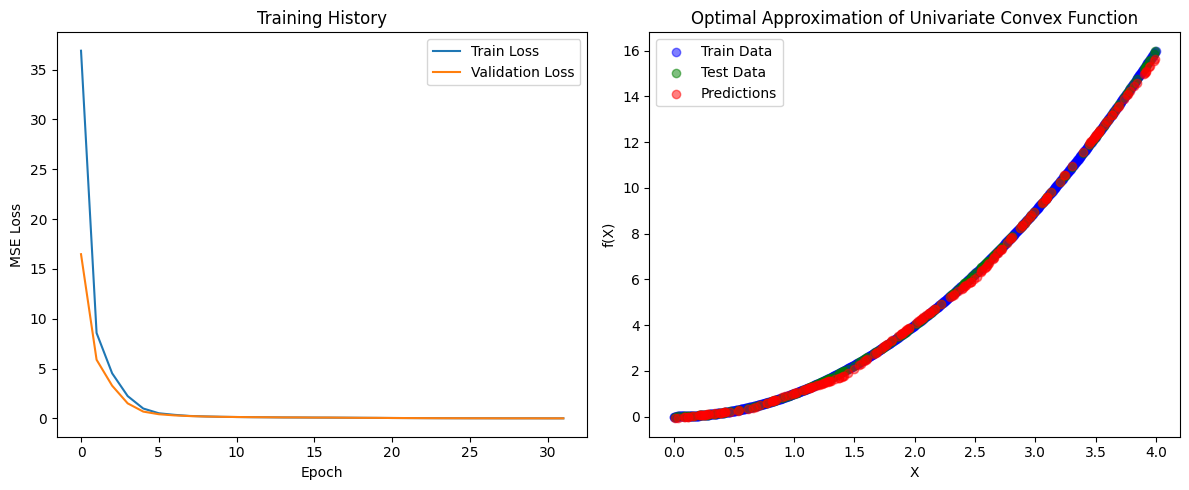

In [9]:
plot_results_1d(
    X_train, y_train, X_val, y_val, y_pred,
    history,
    title='Optimal Approximation of Univariate Convex Function'
)

**That's indeed a good start!**

But would the model be able to approximate any more complex function in a larger range?

In [8]:
FUNCTION = lambda x: x**5 + np.log(x + 5) + np.exp(np.sqrt(x))
A, B = 0, 10

In [9]:
X_train, X_val, y_train, y_val = generate_1d_convex(n_samples=1024, interval=(A, B), func=FUNCTION)
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
model = FFN_Network(input_dim = 1,
                     hidden_layers = 4, # note that the number of hidden layers is increased
                     hidden_units = 10, # and so is the number of hidden units
                     output_dim = 1)
history = train_model(model, train_loader, val_loader, epochs=32, lr=0.01, device=device)

Training Configurations:
Device: cpu
Epochs: 32
Learning Rate: 0.01



Training:   0%|          | 0/32 [00:00<?, ?epoch/s]

In [11]:
test_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
y_pred, y_actual = evaluate_model(model, test_loader, device=device)

Evaluation Configurations:
Device: cpu



Evaluating:   0%|          | 0/7 [00:00<?, ?batch/s]

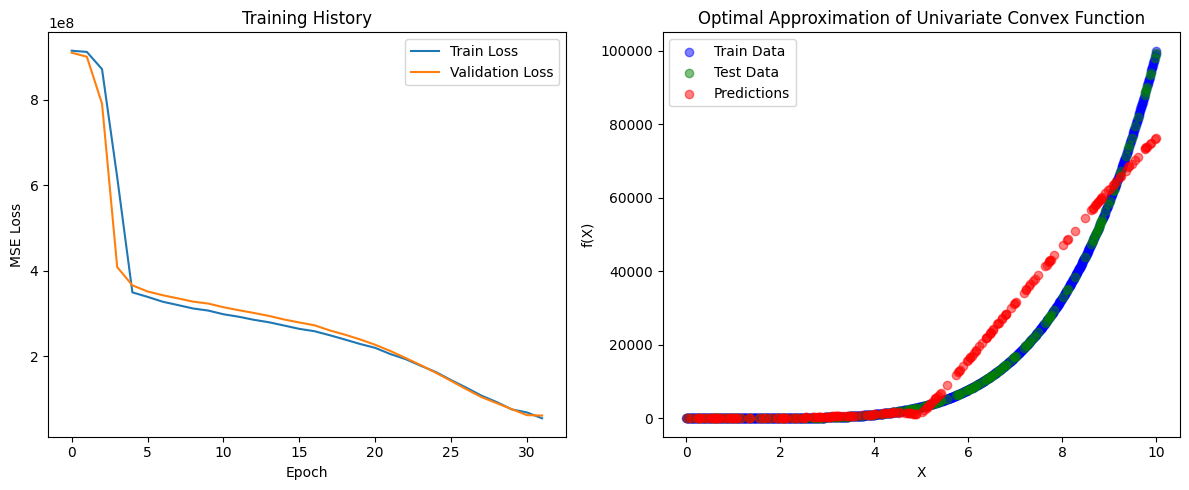

In [14]:
plot_results_1d(
    X_train, y_train, X_val, y_val, y_pred,
    history,
    title='Optimal Approximation of Univariate Convex Function'
)

### ⚠️ Yikes, that's a little too much for the model to handle!

Even though we increased the depth and width of the network, the approximation is still far from the true function. This highlights a real-world challenge — **deep networks are not magic**, especially when dealing with highly nonlinear or steep convex functions. The low MSE Loss shows that the model is doing its best to approximate the function (potentially overfitting), but the approximation is still not satisfactory.

In many practical situations, we don’t have perfect access to high-resolution data or unlimited model capacity. In fact, we may have to deal with **noisy**, **incomplete**, or **low-resolution** data. Sometimes, data is only provided at a **few discrete points**, or even displayed visually as an **image** which needs to be processed.

This is why understanding the **limitations** of neural network approximators is crucial — both from a **theoretical** and **practical** standpoint.

---

### 🔄 Let's take a step back

Before diving into approximation theory, we'll return to a **simpler function** to build some intuition. Let's consider:

$$
f(x) = x^2, \quad \text{for } x \in [0, 1]
$$

This function is:
- ✅ Convex
- ✅ Smooth
- ✅ Continuous

In [12]:
FUNCTION = lambda x: x**2
A, B = 0, 1

By reproducing the maths in the research paper, we can compute the theoretical approximation error.

In [13]:
error = compute_approximation_error(f=FUNCTION, interval=(A, B))
error["error"]

0.125

### Why is the error $\Delta(S^*) = 0.125$ ?

The optimal approximation error for a convex univariate function is calculated using the formula:

$$
\Delta(S^*) = \frac{c-a}{2} \left[f'(c) - f'(d)\right]
$$

#### Given
1. The function is $f(x) = x^2$, defined over the interval $[0, 1]$.
2. The derivative of the function is $f'(x) = 2x$.

We aim to calculate the **optimal approximation error** $\Delta(S^*)$ for the function $f(x) = x^2$ over the interval $[0, 1]$.

---

#### Step 1: Compute \( c \)

From the formula for \( c \):

$$
f'(c) = \frac{f(b) - f(a)}{b-a}
$$

Substitute the values:
- $f(b) = 1^2 = 1$
- $f(a) = 0$
- $b - a = 1 - 0 = 1$

Thus:

$$
f'(c) = \frac{1 - 0}{1} = 1
$$

Since $f'(x) = 2x$, we have:

$$
2c = 1 \quad \Rightarrow \quad c = 0.5
$$

---

#### Step 2: Compute $d$

From the formula for $d$:

$$
f'(d) = \frac{f(c) - f(a)}{c-a}
$$

Substitute the values:
- $f(c) = (0.5)^2 = 0.25$
- $f(a) = 0$
- $c - a = 0.5 - 0 = 0.5$

Thus:

$$
f'(d) = \frac{0.25 - 0}{0.5} = 0.5
$$

---

#### Step 3: Compute $\Delta(S^*)$

Using the formula for $\Delta(S^*)$:

$$
\Delta(S^*) = \frac{c-a}{2} \left[f'(c) - f'(d)\right]
$$

Substitute the values:
- $c - a = 0.5 - 0 = 0.5$
- $f'(c) = 1$
- $f'(d) = 0.5$

Thus:

$$
\Delta(S^*) = \frac{0.5}{2} \left[1 - 0.5\right]
$$

Simplify:

$$
\Delta(S^*) = \frac{0.5}{2} \cdot 0.5 = 0.125
$$

---

### Conclusion

The optimal approximation error is:

$$
\Delta(S^*) = 0.125
$$

This result is derived from the specific properties of the function $f(x) = x^2$ and the optimal conditions for piecewise linear approximation over the interval $[0, 1]$.


$\textbf{Lemma 2}$: For convex functions $f(x)$, if one enlarges $[a, b]$ by moving the endpoint $b$ to the right, or $a$ to the left, the optimal approximation error $\Delta(S^*)$ of the function $f(x)$ by a line segment S(x) will increase. On the contrary, if one reduces the interval $[a, b]$ by moving the endpoint $b$ to the left, or $a$ to the right, the optimal approximation error $\Delta(S^*)$ will decrease.

In [19]:
a, b = -1, 2 # move b to the right, and a to the left
error = compute_approximation_error(f=FUNCTION, interval=(a, b))
error = error["error"]
print(f"\nTheoretical Approximation Error: {error}, larger than before")


Theoretical Approximation Error: 1.125, larger than before


In [20]:
a, b = 0, 0.7 # move b to the left
error = compute_approximation_error(f=FUNCTION, interval=(a, b))
error = error["error"]
print(f"\nTheoretical Approximation Error: {error}, smaller than before")


Theoretical Approximation Error: 0.06124999999999999, smaller than before


#### Sufficient Conditions:
Once the chain of equalities holds, any movements of interior endpoints will cause ${\Delta(f'_n)}$ to increase, and subsequent sewing neighboring segments at common endpoints to make $f_n$ be continuous will increase ${\Delta(f'_n)}$ further. Therefore, the chain of equalities below is sufficient for optimal approximation.

$$
    \Delta(S^*_1) = \Delta(S^*_2) = \Delta(S^*_3) = \cdots = \Delta(S^*_n) = \Delta(f^*_n)
$$

#### Uniqueness:

We will prove it by contradiction. 
Assume there are two different optimal piecewise linear functions with the same approximation errors. Geometrically, there must exist two intervals with one of them being included in another, such as $[a, e]$ and $[a, e_1]$ due to the fact that endpoints $a$ and $b$ are fixed. 

By the assumption that the two configurations have equal optimal approximation errors and the optimality conditions, one has 
$$
\Delta(f^*_3) = \Delta(S^*_{\substack{ae}}); \Delta(f^*_3) = \Delta(S^*_{\substack{ae_1}}) \quad \tag{3.15}
$$
However, $[a, e]$ and $[a, e_1]$ have different lengths, by lemma 2 which claims the monotony of optimal approximation error with respect to interval length, we have
$$
\Delta(S^*_{\substack{ae}}) \neq \Delta(S^*_{\substack{ae_1}}),
$$
which contradicts $(3.15)$. As a result, the optimal approximation $f^*_n(x)$ is unique.

## Chapter 2: Approximation Bounds and Convergence Rates
This chapter explores the approximation capacity and convergence rate of neural networks, with a focus on the theoretical foundations like Lemmas and Theorems that describe when and how well a neural network can approximate a given function. We discuss bounds, both upper and lower, and compare them with numerical observations when applicable.

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from data.generators import *
from utils.trainer import train_model
from utils.evaluator import evaluate_model
from utils.visualizer import *
from utils.maths import *
from model.simple_model import FFN_Network
from typing import Callable

In [15]:
FUNCTION = lambda x: x**2
A = 0
B = 1

In [23]:
error = compute_approximation_error(f = FUNCTION, interval=(A,B))
error["error"]

0.125

### Explanation for the error $\Delta(S^*)$
The explanation for the error $\Delta(S^*)$ being $0.125$ is provided above. Readers are encouraged to refer to that for a detailed explanation.

In [24]:
assert error['c'] == (B+A)/2
print("C is the midpoint of the interval [A, B], as expected.")

assert error['d'] == (error['c'] + A)/2
print("D is the midpoint between C and A, as expected.")

C is the midpoint of the interval [A, B], as expected.
D is the midpoint between C and A, as expected.



We observe that the optimal approximation occurs at $C$, which is the midpoint of the interval $[A, B]$.
This is because the second derivative of the function $f(x) = x^2$ is constant and equal to $2$.

Mathematically, this can be expressed as:
$$
f''(x) = 	constant
$$

For a quadratic function, $f(x)$ can be written in terms of its second derivative as:
$$
f(x) = [0.5 \cdot f''(x)] \cdot x^2 + k \cdot x + e,
$$
where $k$ and $e$ are constants.

The derivative at the midpoint $c$ can be calculated as:
$$
f'(c) = \frac{f(b) - f(a)}{b - a}.
$$

Substituting the values of $f(b)$ and $f(a)$ into the equation:
$$
f'(c) = \frac{\left( \frac{f'' \cdot b^2}{2} + k \cdot b \right) - \left( \frac{f'' \cdot a^2}{2} + k \cdot a \right)}{b - a}.
$$

Simplifying further:
$$
f'(c) = \frac{f'' \cdot (b-a) \cdot (b+a)}{2(b-a)} + k.
$$

This reduces to:
$$
f'(c) = \frac{f'' \cdot (b+a)}{2} + k = f'' \cdot c + k.
$$

This implies that $c = \frac{a+b}{2}$ is the optimal approximation for the function $f(x)$ when $f''(x)$ is constant.

Similarly, it can be shown that $d = \frac{c+a}{2}$ is the midpoint between $c$ and $a$, providing further approximation points.

### Proof of Theorem 2: Bounds on Approximation Error

For any convex function $f(x)$, we construct a function $\bar{f}(x)$ which has a constant second-order derivative $\bar{f}''(x) = \max_{x \in [a,b]} f''(x)$

#### Upper Bound
The upper bound of $\Delta(f_n^*)$ is derived as follows:
$$
\Delta(f_n^*) \leq \frac{(b-a)^2}{16 \cdot n^2} \cdot \max_{x \in [a,b]} f''(x).
$$

*Proof.* 

Since $\bar{f}(x)$ is more convex than $f(x)$, when using piecewise linear functions with $n$ segments to approximate them, $\Delta(f_n^*)$ will be upper bounded by the optimal approximation error $\Delta(\bar{f}_n^*)$ of function $\bar{f}(x)$. It implies:
$$
\Delta(f_n^*) = \Delta(S_i^*) \leq \Delta(\bar{f}_n^*) = \Delta(\bar{S}_i^*) = \frac{c_i - a_i}{2} \cdot \left[ \bar{f}'(c_i) - \bar{f}'(d_i) \right]
$$

where $c_i$ and $d_i$ are determined by function $\bar{f}(x)$, lie at the midpoint of each segment $[a_i, b_i]$, $[a_i, c_i]$ respectively. Mathematically:
$$
c_i - a_i = \frac{b_i - a_i}{2}, \quad d_i - a_i = \frac{b_i - a_i}{4}.
$$

Substituting these values, we have:
$$
\Delta(f_n^*) \leq \frac{c_i - a_i}{2} \cdot \bar{f}'' \cdot [c_i - d_i] = \frac{b_i - a_i}{4} \max_{x \in [a,b]} f''(x) \left[ \frac{b_i - a_i}{2} - \frac{b_i - a_i}{4} \right]
= \frac{(b_i - a_i)^2}{16} \max_{x \in [a,b]} f''(x)
$$

Consider the segment corresponding to the shortest interval for which we have $b_i - a_i \leq \frac{b-a}{n}$, thereby we get the following upper bound,
$$
\Delta(f_n^*) \leq \frac{(b-a)^2}{16 \cdot n^2} \cdot \max_{x \in [a,b]} f''(x).
$$

#### Lower Bound
Similarly, the lower bound is:
$$
\Delta(f_n^*) \geq \Delta(\underline{f}_n^*) \geq \frac{(b-a)^2}{16 \cdot n^2} \cdot \min_{x \in [a,b]} f''(x).
$$

#### Final Result
Combining both bounds, we conclude:
$$
\frac{(b-a)^2}{16 \cdot n^2} \cdot \min_{x \in [a,b]} f''(x) \leq \Delta(f_n^*) \leq \frac{(b-a)^2}{16 \cdot n^2} \cdot \max_{x \in [a,b]} f''(x).
$$

This completes the proof of Theorem 2.

### Convergence Rate
The convergence rate of the error $\Delta(f_n^*)$ is $\mathcal{O}(n^{-2})$. This implies that the error decreases quadratically with the number of segments $n$.

Since $b-a$ is irrelevant to the convergence rate while being the interval length, the error is independent of the interval length. Meanwhile, minimal and maximal second derivatives are crucial for the error bounds, also not affecting the convergence rate.

Therefore, the error $\Delta(f_n^*)$ is independent of the interval length and converges quadratically with the number of segments $n$. In other words, the Convergence Rate is $\mathcal{O}(n^{-2})$.

## Chapter 3: ReLU Network and Piecewise Linear Regression
In this chapter, we examine a ReLU-based regression network as a case study of function approximation.

#### Limitations of Regression Networks
While regression networks are commonly used for function approximation, they exhibit several weaknesses:
- **High Complexity**: These networks often require a large number of neurons or layers to approximate complex nonlinear functions accurately. This leads to increased computational costs.
- **Generalization Issues**: Regression networks trained on specific data ranges may perform poorly on unseen data, particularly when the function has high variation.
- **Local Approximation**: Due to their piecewise linear nature, ReLU networks may approximate well only in local regions and fail to capture global behaviors.

#### Example Limitations
- For instance, approximating a sinusoidal function using ReLU-based networks would require many linear pieces to mimic the curvature, resulting in overparameterization.
- In contrast, a polynomial approximation or Fourier-based method may achieve better performance with fewer parameters in such cases.

These limitations motivate the need for improved architectures or hybrid models that can balance expressiveness with efficiency — a key direction in ongoing scientific research.

### Import Libraries and Models
- Imports necessary libraries
- Imports the `ReluSegmentNetwork` and `FixedWidthReluNetwork` models from the `model.piecewise_linear_fn` modules
- Includes utility functions from the `utils.maths` modules

In [16]:
import torch
import matplotlib.pyplot as plt
from model.piecewise_linear_fn import ReluSegmentNetwork, FixedWidthReluNetwork
from utils.maths import *

### Fixed-Depth Relu Network

#### Define and Plot Data Points
- Defines `x_points` and `y_points`, which represent the breakpoints and values of a piecewise linear function.
- Visualizes these data points using a scatter plot.

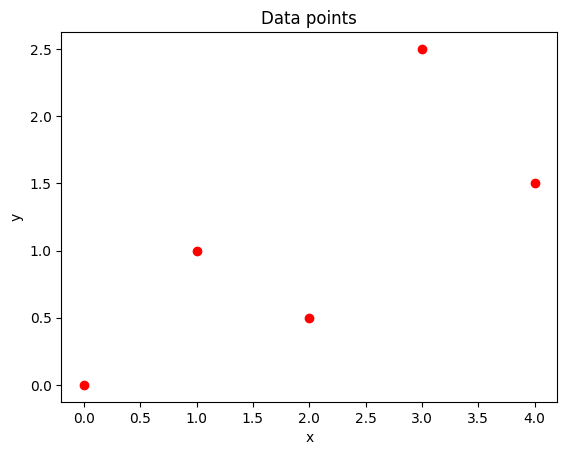

In [18]:
x_points = [0, 1, 2, 3, 4]
y_points = [0, 1, 0.5, 2.5, 1.5]

# plot
plt.plot(x_points, y_points, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data points')
plt.show()

#### Initialize `ReluSegmentNetwork`
- Instantiates the `ReluSegmentNetwork` model using the defined `x_points` and `y_points`.

In [19]:
model = ReluSegmentNetwork(
    x_points=x_points,
    y_points=y_points
)

#### Generate Function Values for `ReluSegmentNetwork`
- Defines a range of `x` values for evaluating the model.

- Uses the model to compute:
  - Base value $f_n^*(x_1)$,
  - Outputs of individual segments ($O_i$).

- Calculates the reconstructed piecewise linear function ($f_x$) by summing these components.
- Computes the original piecewise linear function using a mask for comparison.

In [20]:
x = torch.linspace(-1, 10, 500)

with torch.no_grad():
    base_value, segment_outputs = model(x)

f_x = base_value + sum(segment_outputs)

original_f_x = torch.zeros_like(x)
for i in range(len(x_points) - 1):
    mask = (x >= x_points[i]) & (x < x_points[i + 1])
    original_f_x[mask] = (
        y_points[i]
        + (x[mask] - x_points[i])
        * (y_points[i + 1] - y_points[i])
        / (x_points[i + 1] - x_points[i])
    )
original_f_x[x >= x_points[-1]] = y_points[-1]  # Handle the last point

#### Plot Results for `ReluSegmentNetwork`
- Creates two subplots:
  - Original piecewise linear function, connecting `x_points` and `y_points`.
  - Reconstructed function generated by `ReluSegmentNetwork`.
- Configures axes, legends, and grid for clarity.

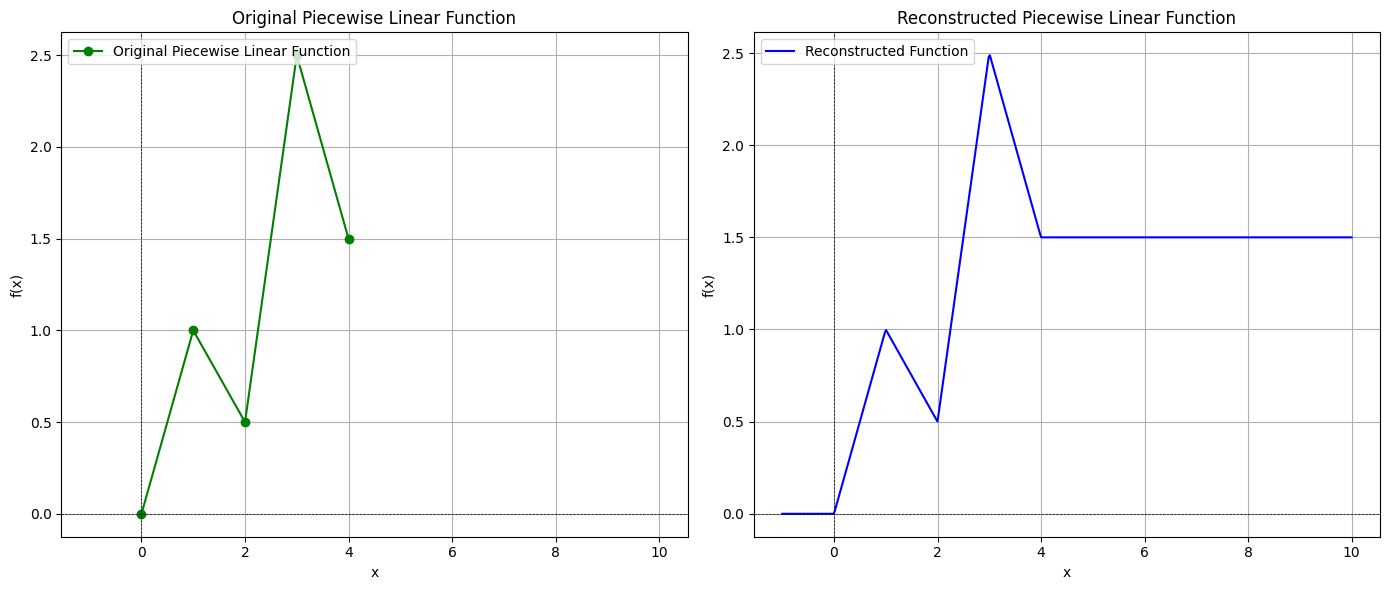

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Plot the original piecewise linear function by connecting the given x,y coordinates
axs[0].plot(x_points, y_points, label="Original Piecewise Linear Function", color="green", marker="o")
axs[0].set_title("Original Piecewise Linear Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].axhline(0, color="black", linewidth=0.5, linestyle="--")
axs[0].axvline(0, color="black", linewidth=0.5, linestyle="--")
axs[0].legend(loc="upper left")
axs[0].grid()

# Plot the reconstructed piecewise linear function
axs[1].plot(x.numpy(), f_x.numpy(), label="Reconstructed Function", color="blue")
axs[1].set_title("Reconstructed Piecewise Linear Function")
axs[1].set_xlabel("x")
axs[1].set_ylabel("f(x)")
axs[1].axhline(0, color="black", linewidth=0.5, linestyle="--")
axs[1].axvline(0, color="black", linewidth=0.5, linestyle="--")
axs[1].legend(loc="upper left")
axs[1].grid()

plt.tight_layout()
plt.show()

The reconstructed function closely matches the original piecewise linear function, demonstrating the model's ability to approximate the function. The plot in given interval matches perfectly with the original function, while the plot outside the interval has $f(x)$ staying constant at the last value of the interval.

### Fixed-Width Relu Network

#### Define and Plot New Data Points
- Redefines `x_points` and `y_points` to represent a different piecewise linear function.
- Visualizes the new data points.

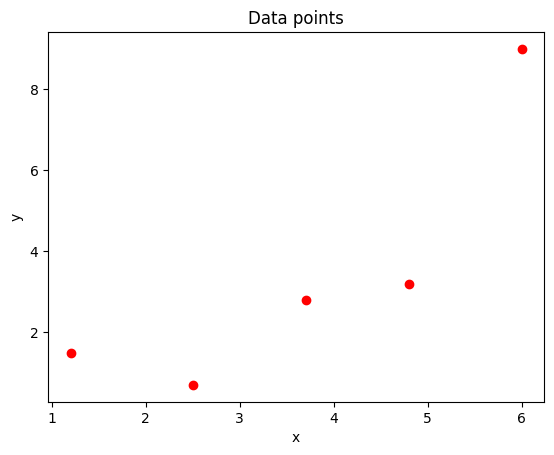

In [21]:
x_points = [1.2, 2.5, 3.7, 4.8, 6.0]
y_points = [1.5, 0.7, 2.8, 3.2, 9.0]

# plot
plt.plot(x_points, y_points, 'ro')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data points')
plt.show()

#### Initialize `FixedWidthReluNetwork`
- Instantiates the `FixedWidthReluNetwork` model using the new `x_points` and `y_points`.

In [22]:
fixed_model = FixedWidthReluNetwork(
    x_points=x_points,
    y_points=y_points
)

#### Generate and Plot Results for `FixedWidthReluNetwork`
- Evaluates the model over the range of $x$ values.
- Creates two subplots:
  - Original piecewise linear function, connecting the new `x_points` and `y_points`.
  - Reconstructed function generated by `FixedWidthReluNetwork`.
- Ensures shared axes for direct comparison.

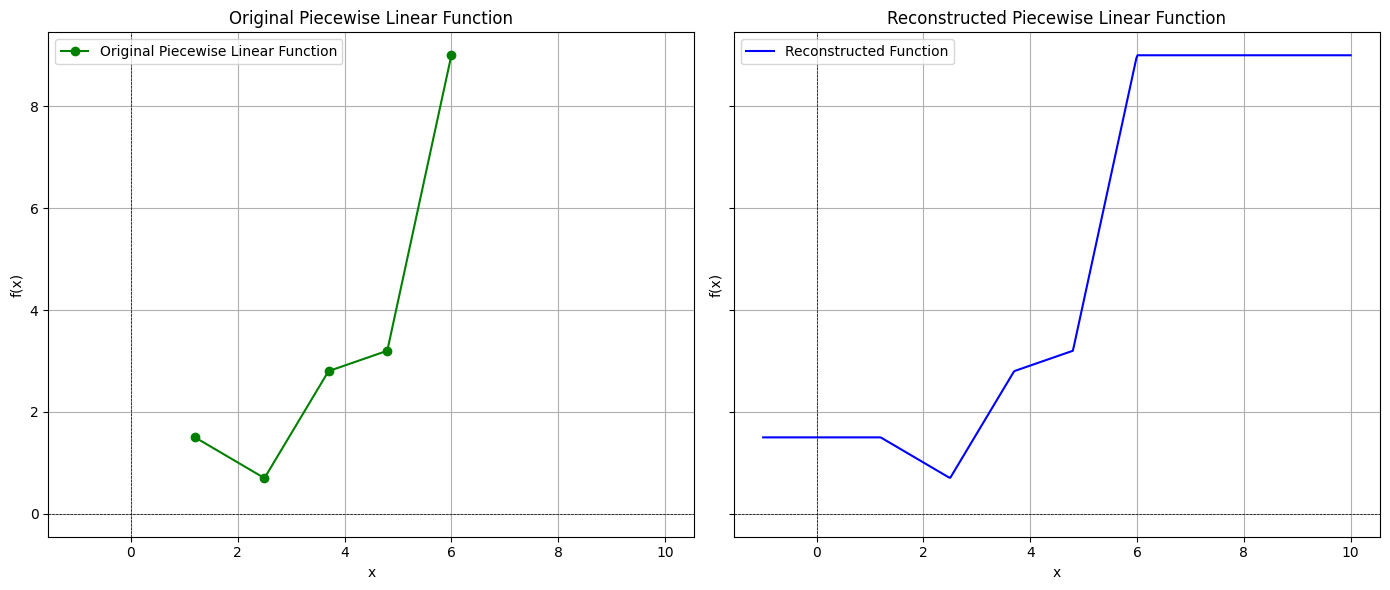

In [32]:
x = torch.linspace(-1, 10, 500)

# Compute the function output
with torch.no_grad():
    f_x = fixed_model(x)

# Visualize the results
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot the original piecewise linear function by connecting the given x, y coordinates
axs[0].plot(x_points, y_points, label="Original Piecewise Linear Function", color="green", marker="o")
axs[0].set_title("Original Piecewise Linear Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].axhline(0, color="black", linewidth=0.5, linestyle="--")
axs[0].axvline(0, color="black", linewidth=0.5, linestyle="--")
axs[0].legend(loc="upper left")
axs[0].grid()

# Plot the reconstructed piecewise linear function
axs[1].plot(x.numpy(), f_x.numpy(), label="Reconstructed Function", color="blue")
axs[1].set_title("Reconstructed Piecewise Linear Function")
axs[1].set_xlabel("x")
axs[1].set_ylabel("f(x)")
axs[1].axhline(0, color="black", linewidth=0.5, linestyle="--")
axs[1].axvline(0, color="black", linewidth=0.5, linestyle="--")
axs[1].legend(loc="upper left")
axs[1].grid()

plt.tight_layout()
plt.show()

## Chapter 4: Algorithms and Analysis
In this final section, we explore the algorithmic aspects of neural approximation. We introduce functions and utilities as needed during the explanation of each algorithm. 

### Imports
The necessary libraries are imported.

In [23]:
from utils.algo import optimal_approx
from utils.maths import *
import numpy as np
import pandas as pd

### Function Definitions
The next few cells will define the functions used in the experiment

In [24]:
def square(x):
    return x**2

def triplet(x):
    return x**3

def exp(x):
    return np.exp(x)

In [25]:
n = [2, 3, 5, 10]
step = 2e-5

Below is the function to calculate the mean error.

In [26]:
def mean_err(errs):
    return sum(errs) / len(errs)

Also, the boundings of the error are defined along with the maximal gap between errors.

In [27]:
def bounds(n, f, a, b):
    pass

### Start approximating variables
This step implements the algorithm to approximate the variables in the system of equations, as described in the paper.

In [28]:
errs = []

In [29]:
for i in n:
    print(f"n = {i}")
    print(f"f(x) = exp(x)")
    a, b = 0, 1
    alpha = (b-a)**2 / (16 * i**2)
    res = optimal_approx(i, exp, a, b, step)
    errs.append({
        "function": "exp(x)",
        "n": i,
        "mean_err": mean_err(res[1]),
        "upper_bound": max_fx(get_derivative(get_derivative(exp)), (a, b)) * alpha,
        "lower_bound": min_fx(get_derivative(get_derivative(exp)), (a, b)) * alpha,
        "max_gap": max(res[1]) - min(res[1]),
        "rounds": res[2]
    })
    print('-'*50)

n = 2
f(x) = exp(x)


Optimal Approximation:   0%|          | 0/1 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
n = 3
f(x) = exp(x)


Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

--------------------------------------------------
n = 5
f(x) = exp(x)


Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------------------------------------
n = 10
f(x) = exp(x)


Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------


In [30]:
for i in n:
    print(f"n = {i}")
    print(f"f(x) = x^2")
    a, b = -1, 1
    alpha = (b-a)**2 / (16 * i**2)
    res = optimal_approx(i, square, a, b, step)
    errs.append({
        "function": "x^2",
        "n": i,
        "mean_err": mean_err(res[1]),
        "upper_bound": max_fx(get_derivative(get_derivative(square)), (a, b)) * alpha,
        "lower_bound": min_fx(get_derivative(get_derivative(square)), (a, b)) * alpha,
        "max_gap": max(res[1]) - min(res[1]),
        "rounds": res[2]
    })
    print('-'*50)

n = 2
f(x) = x^2


Optimal Approximation:   0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
n = 3
f(x) = x^2


Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

--------------------------------------------------
n = 5
f(x) = x^2


Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------------------------------------
n = 10
f(x) = x^2


Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------


In [31]:
for i in n:
    print(f"n = {i}")
    print(f"f(x) = x^3")
    a, b = 0, 1
    alpha = (b-a)**2 / (16 * i**2)
    res = optimal_approx(i, triplet, a, b, step)
    errs.append({
        "function": "x^3",
        "n": i,
        "mean_err": mean_err(res[1]),
        "upper_bound": max_fx(get_derivative(get_derivative(triplet)), (a, b)) * alpha,
        "lower_bound": min_fx(get_derivative(get_derivative(triplet)), (a, b)) * alpha,
        "max_gap": max(res[1]) - min(res[1]),
        "rounds": res[2]
    })
    print('-'*50)

n = 2
f(x) = x^3


Optimal Approximation:   0%|          | 0/1 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/1 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/1 [00:00<?, ?it/s]

--------------------------------------------------
n = 3
f(x) = x^3


Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/2 [00:00<?, ?it/s]

--------------------------------------------------
n = 5
f(x) = x^3


Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/4 [00:00<?, ?it/s]

--------------------------------------------------
n = 10
f(x) = x^3


Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

Optimal Approximation:   0%|          | 0/9 [00:00<?, ?it/s]

--------------------------------------------------


### Results
The results are displayed in the form of a table, showing values that are really close to published values in the paper.

In [42]:
df = pd.DataFrame(errs)
df

,function,n,mean_err,upper_bound,lower_bound,max_gap,rounds
0,exp(x),2,0.026349,0.042445,1.562292e-02,0.000003,3089
1,exp(x),3,0.011699,0.018865,6.943520e-03,0.000004,5544
2,exp(x),5,0.004210,0.006791,2.499667e-03,0.000006,10054
3,exp(x),10,0.001055,0.001698,6.249168e-04,0.000319,13138
4,x^2,2,0.125000,0.125011,1.249990e-01,0.000000,0
5,x^2,3,0.055556,0.055560,5.555510e-02,0.000007,1
6,x^2,5,0.020000,0.020002,1.999984e-02,0.000008,4
7,x^2,10,0.005000,0.005000,4.999959e-03,0.000003,6
8,x^3,2,0.044863,0.093750,6.525807e-07,0.000006,5775
9,x^3,3,0.019462,0.041667,2.900359e-07,0.000008,11183


## Conclusion

In this study, we addressed the problem of optimally approximating a convex function $f(x)$ using a limited number $n$ of linear segments. We established both necessary and sufficient conditions for optimality and demonstrated its uniqueness. By deriving lower and upper bounds, we showed that the approximation error decreases at a rate of $\mathcal{O}(1/n^{2})$. Furthermore, we introduced ReLU network architectures with fixed depth and width that can construct these optimal linear approximations. Lastly, we proposed a practical algorithm for finding such approximations, proved its convergence, and validated its performance through experimental results.

